In [9]:
import matplotlib.pyplot as plt
import rasterio as rio
from segmetrics import dice_coef_j, dice_coef_s, mean_iou
import os
import numpy as np

from tensorflow import keras
from tensorflow.image import resize
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import MeanIoU, BinaryAccuracy

from tensorflow.keras import Model, Sequential
from tensorflow import random_normal_initializer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

In [10]:
tiled_images_dir = "./data/brooklyn/tiles/images/"
tiled_masks_dir  = "./data/brooklyn/tiles/masks/"


tiled_img_paths = sorted([tiled_images_dir+"train/"+file for file in os.listdir(tiled_images_dir+"train/")
                   if file.endswith(".tif")])

tiled_mask_paths = sorted([tiled_masks_dir+"labels/"+file for file in os.listdir(tiled_masks_dir+"labels/")
                       if file.endswith(".tif")])

len(tiled_img_paths), len(tiled_mask_paths)

(2040, 2040)

In [11]:
def plot_img_with_mask(index, raster_img_paths = tiled_img_paths, mask_img_paths = tiled_mask_paths):
    tif_file = rio.open(raster_img_paths[index], mode = "r+").read().transpose(1,2,0)
    mask_file = rio.open(mask_img_paths[index], mode = "r+").read().transpose(1,2,0)
    plt.figure(figsize = (10,10))
    plt.imshow(tif_file)
    plt.imshow(mask_file, alpha =  0.75, cmap = "inferno")

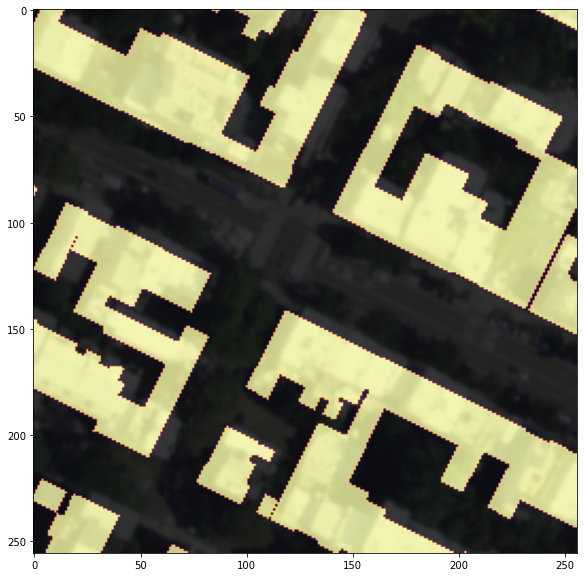

In [12]:
plot_img_with_mask(72)

In [13]:
img_dg = ImageDataGenerator(rescale=1/255., rotation_range=90.,
                            width_shift_range=0.1, height_shift_range=0.1,
                            zoom_range=0.2,
                            fill_mode="constant", cval = 0,
                            validation_split=0.15)
val_dg = ImageDataGenerator(rescale = 1/255., validation_split = 0.15)

In [14]:
seed = 2022
img_size = (256,256)
batch_sz = 16
#augmented_dir = "./data/augmented_images/"

train_image_generator = img_dg.flow_from_directory(tiled_images_dir, target_size=img_size, class_mode=None,
                                                   batch_size=batch_sz, shuffle=True, seed=seed,
                                                   subset="training")
                                                   #save_to_dir=augmented_dir+"train_images/", save_format="tif")

train_mask_generator  = img_dg.flow_from_directory(tiled_masks_dir, target_size=img_size, class_mode=None,
                                                   batch_size=batch_sz, shuffle=True, color_mode = "grayscale", seed=seed,
                                                   subset="training")
                                                   #save_to_dir=augmented_dir+"train_masks/", save_format="tif")

val_image_generator = val_dg.flow_from_directory(tiled_images_dir, target_size=img_size, class_mode=None,
                                                 batch_size=batch_sz, shuffle=True, seed=seed,
                                                 subset="validation")
                                                 #save_to_dir=augmented_dir+"val_images/", save_format="tif")

val_mask_generator  = val_dg.flow_from_directory(tiled_masks_dir, target_size=img_size, class_mode=None,
                                                 batch_size=batch_sz, shuffle=True, color_mode = "grayscale", seed=seed,
                                                 subset="validation")
                                                 #save_to_dir=augmented_dir+"val_masks/", save_format="tif")

Found 1734 images belonging to 1 classes.
Found 1734 images belonging to 1 classes.
Found 306 images belonging to 1 classes.
Found 306 images belonging to 1 classes.


In [19]:
train_generator = zip(train_image_generator,train_mask_generator)
val_generator   = zip(val_image_generator, val_mask_generator)

In [20]:
best_model = keras.models.load_model("segmentation_model1_checkpoint.keras",
                                     custom_objects={
                                         "dice_coef_j":dice_coef_j,
                                         "dice_coef_s":dice_coef_s,
                                         "mean_iou":mean_iou
                                     })

In [21]:
def load_img(index, file_list):
    img = rio.open(file_list[index], mode = 'r+').read().transpose(1,2,0)
    img = resize(np.expand_dims(img,axis = 0),(256,256))/255
    return img

def display_image_and_prediction(index=None, models = [best_model], model_names = [""], img_list = tiled_img_paths, mask_list = tiled_mask_paths, thresholds = [0.5]):
    if len(models) != len(model_names):
        print("Not enough model names provided, setting title for unnamed models to empty string.")
        model_names.extend([""]*(len(models) - len(model_names)))
        
    test_image = load_img(index, img_list)
    test_mask  = load_img(index, mask_list)
        
    fig,ax = plt.subplots(nrows=len(models), ncols=3+len(thresholds), figsize = ((len(thresholds)+3)*3, 16))
    if len(models) > 1:
        for i,model in enumerate(models):

            mask_pred = model.predict(test_image)[0]

            ax[i][0].axis("off")
            ax[i][0].imshow(test_image[0])
            ax[i][0].set_title(f"Input Raster ({index})")

            ax[i][1].axis("off")
            ax[i][1].imshow(test_mask[0], cmap = "inferno")
            ax[i][1].set_title("True Mask")

            ax[i][2].axis("off")
            ax[i][2].imshow(mask_pred, cmap = "inferno")
            ax[i][2].set_title(f"Predicted Mask {model_names[i]}")

            for j,t in enumerate(thresholds, start = 3):
                ax[i][j].axis("off")
                ax[i][j].imshow(mask_pred > t, cmap = 'inferno')
                ax[i][j].set_title(f"Predicted Mask {model_names[i]} - Threshold:{t}")
        plt.tight_layout()
    else:
        mask_pred = models[0].predict(test_image)[0]

        ax[0].axis("off")
        ax[0].imshow(test_image[0])
        ax[0].set_title(f"Input Raster ({index})")

        ax[1].axis("off")
        ax[1].imshow(test_mask[0], cmap = "inferno")
        ax[1].set_title("True Mask")

        ax[2].axis("off")
        ax[2].imshow(mask_pred, cmap = "inferno")
        ax[2].set_title(f"Predicted Mask {model_names[0]}")

        for j,t in enumerate(thresholds, start = 3):
            ax[j].axis("off")
            ax[j].imshow(mask_pred > t, cmap = 'inferno')
            ax[j].set_title(f"Predicted Mask {model_names[0]} - Threshold:{t}")
    
    plt.tight_layout()

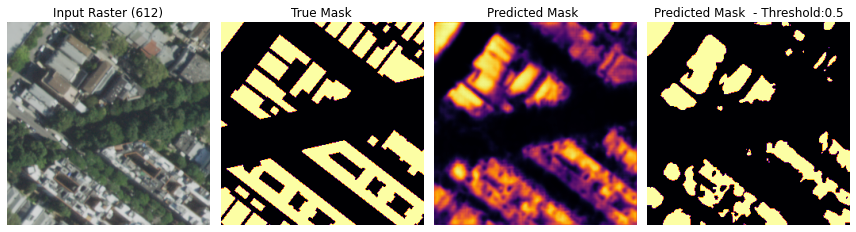

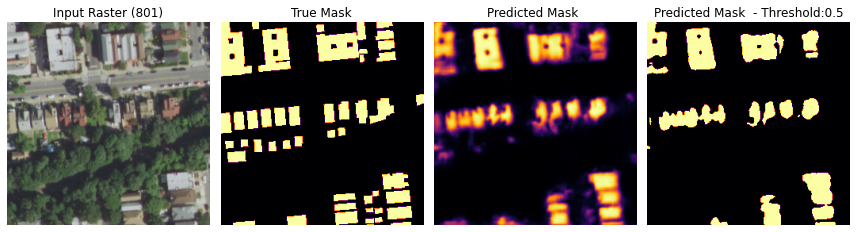

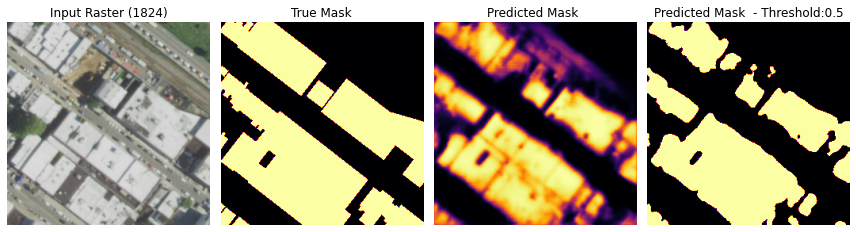

In [103]:
for _ in range(3):
    img_index = np.random.choice(len(tiled_img_paths))
    display_image_and_prediction(img_index);

In [104]:
best_model.evaluate(val_generator,steps = val_image_generator.samples // 16)

19/19 [==============================] - 1s 29ms/step - loss: 0.4450 - dice_coef_j: 0.6911 - dice_coef_s: 0.5890 - mean_iou: 0.4368


[0.4449827969074249,
 0.6911434531211853,
 0.5889881253242493,
 0.43675708770751953]

In [105]:
vgg_model = keras.models.load_model("vgg_model_checkpoint.keras",
                                     custom_objects={
                                         "dice_coef_j":dice_coef_j,
                                         "dice_coef_s":dice_coef_s,
                                         "mean_iou":mean_iou
                                     })

In [106]:
vgg_model.evaluate(val_generator,steps = val_image_generator.samples // 16)

19/19 [==============================] - 2s 89ms/step - loss: 0.4527 - dice_coef_j: 0.7206 - dice_coef_s: 0.6242 - mean_iou: 0.4735


[0.4527420103549957,
 0.7206125259399414,
 0.6242366433143616,
 0.47350355982780457]

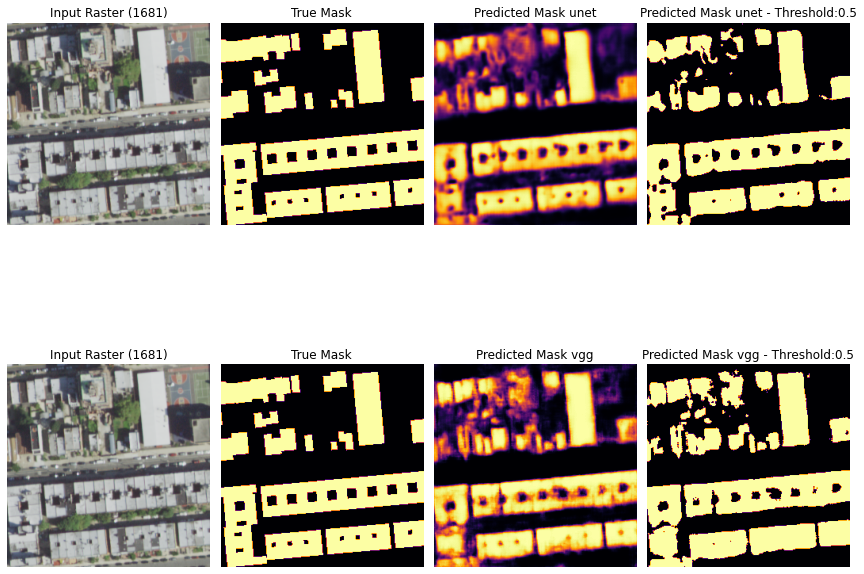

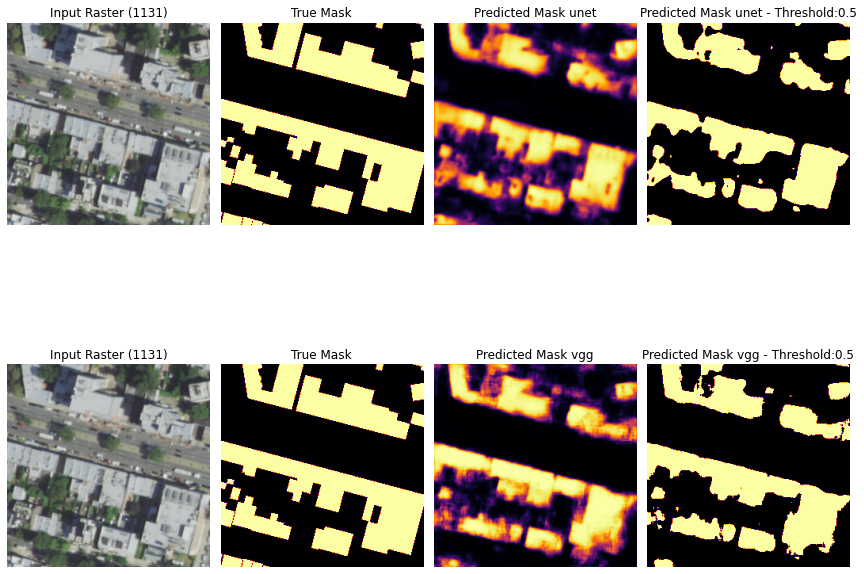

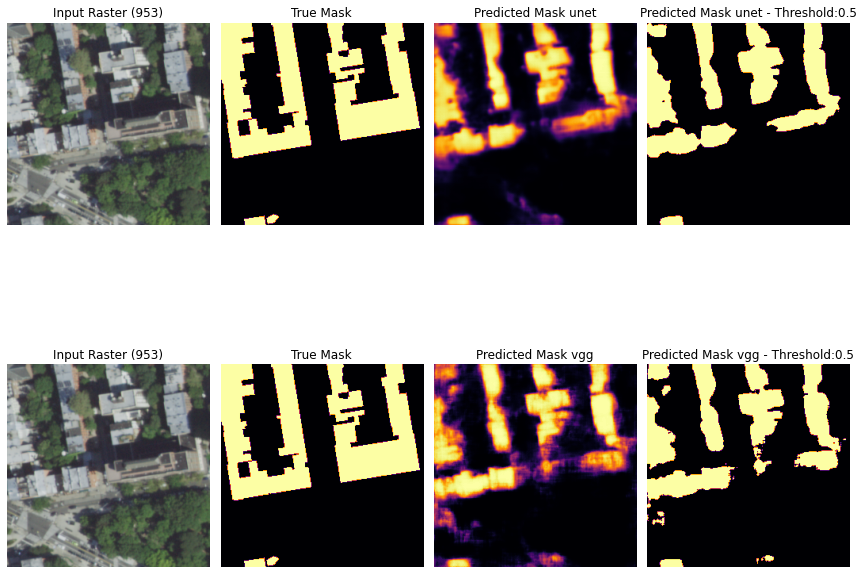

In [108]:
for _ in range(3):
    img_index = np.random.choice(len(tiled_img_paths))
    display_image_and_prediction(img_index, models=[best_model,vgg_model], model_names=["unet","vgg"]);